# Questions for today

- How do we handle class imbalance in deaths? This makes it difficult to see which features it correlates with
- Do we include the target variable in outlier detection? In Mahalanobis?


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from scipy.spatial import distance
from statsmodels.tsa.seasonal import STL

# Reading in Data

In [2]:
# Vitaldb dataset

df_info = pd.read_csv("https://api.vitaldb.net/cases")
df_ids = pd.read_csv("https://api.vitaldb.net/trks")
df_lab = pd.read_csv("https://api.vitaldb.net/labs")

In [3]:
def get_data_for(tid):
    data = pd.read_csv(f"https://api.vitaldb.net/{tid}")
    arr = np.array(data['SNUADC/ECG_II'])
    time_array = np.linspace(0, np.array(data['Time'])[-1], len(data))
    return time_array, arr
    

In [4]:
info = df_info[['subjectid', 'age', 'height', 'weight', 'sex', 'opstart', 'opend', 'approach', 'icu_days', 'death_inhosp']].copy()
info.head()

,subjectid,age,height,weight,sex,opstart,opend,approach,icu_days,death_inhosp
0,5955,77.0,160.2,67.5,M,1668,10368,Open,0,0
1,2487,54.0,167.3,54.8,M,1721,14621,Open,0,0
2,2861,62.0,169.1,69.7,M,1090,3010,Videoscopic,0,0
3,1903,74.0,160.6,53.0,M,2522,17822,Videoscopic,1,0
4,4416,66.0,171.0,59.7,M,2591,20291,Open,13,0


# Data Cleaning/Initial Statistical Exploration 


In [5]:
np.unique(info['approach'])

array(['Open', 'Robotic', 'Videoscopic'], dtype=object)

In [6]:
info_new = info[['subjectid']].copy()
info_new['Age'] = info['age']
info_new['Ht'] = info['height']
info_new['Wt'] = info['weight']
info_new.loc[:,'Sex'] = info.loc[:,'sex'].apply(lambda x: 1 if x == 'F' else 0)
info_new['OP_time'] = (info['opend'] - info['opstart'])/60
one_hot_approaches = pd.get_dummies(info['approach'])
info_new = info_new.join(one_hot_approaches)
info_new['icu_days'] = info['icu_days']
info_new['icu'] = (info['icu_days'] >= 1).apply(lambda x: 1 if x == True else 0)
info_new['death_inhosp'] = info['death_inhosp']

info_new.head()

,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,icu,death_inhosp
0,5955,77.0,160.2,67.5,0,145.0,1,0,0,0,0,0
1,2487,54.0,167.3,54.8,0,215.0,1,0,0,0,0,0
2,2861,62.0,169.1,69.7,0,32.0,0,0,1,0,0,0
3,1903,74.0,160.6,53.0,0,255.0,0,0,1,1,1,0
4,4416,66.0,171.0,59.7,0,295.0,1,0,0,13,1,0


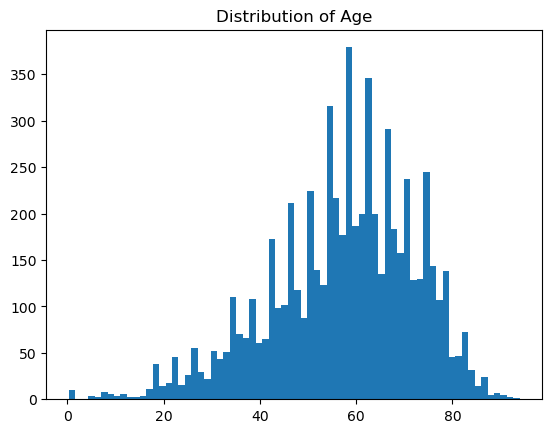

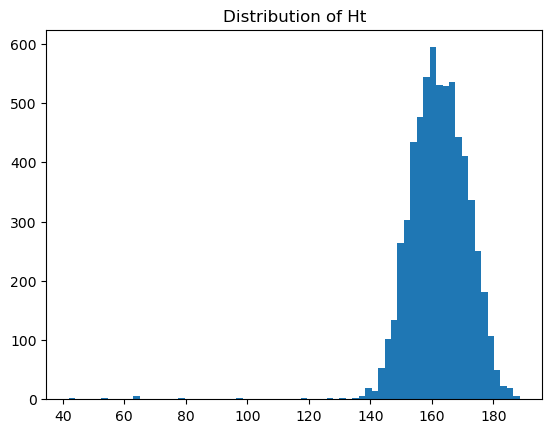

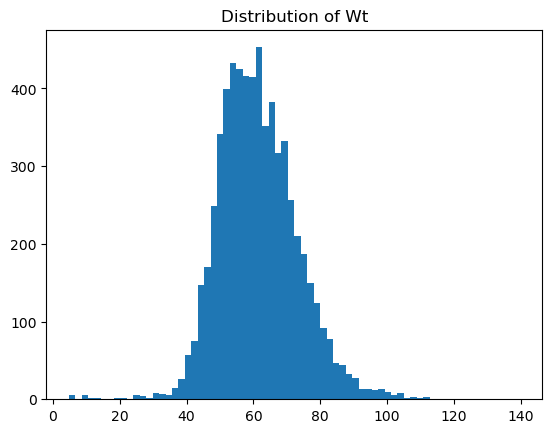

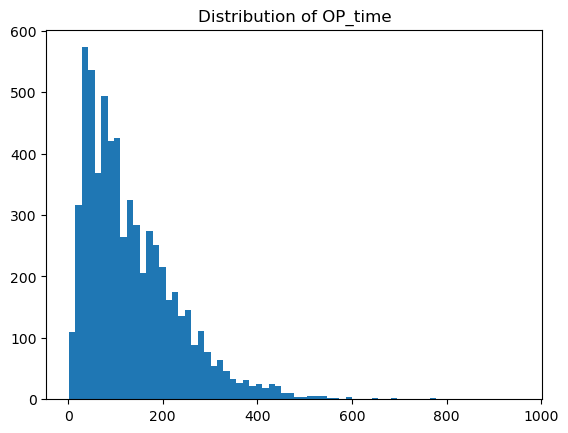

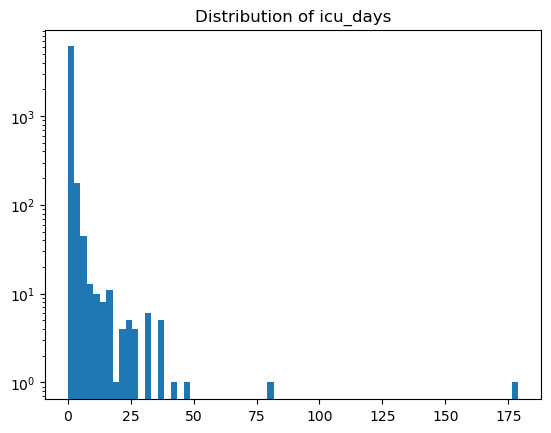

In [7]:
for var in ['Age','Ht','Wt','OP_time', 'icu_days']:
    plt.figure()
    var_unique, counts = np.unique(info_new[var], return_counts=True)
    if var == 'icu_days':
        plt.hist(info_new[var], bins = 70)
        plt.title(f'Distribution of {var}')
        plt.yscale('log')
        plt.show()
    else:
        plt.hist(info_new[var], bins = 70)
        plt.title(f'Distribution of {var}')
        plt.show()

In [8]:
for var in ['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']:
    print(f'For variable {var}:')
    if var in ['Sex', 'Open', 'Robotic', 'Videoscopic', 'icu', 'death_inhosp']:
        print(f'mode={stats.mode(info_new[var]).mode[0]}')
        print(f'class balance: {np.sum(info_new[var])} to {len(info_new)-np.sum(info_new[var])}\n')
    else:
        print(f'mean={np.mean(info_new[var])}')
        print(f'standard deviation={np.std(info_new[var])}\n')

For variable Age:
mean=57.2964934251722
standard deviation=14.975289087630397

For variable Ht:
mean=162.18883218534754
standard deviation=9.90455404392499

For variable Wt:
mean=61.48492172824045
standard deviation=11.944200387476362

For variable Sex:
mode=0
class balance: 3145 to 3243

For variable OP_time:
mean=135.98546232519305
standard deviation=101.15376625280656

For variable Open:
mode=1
class balance: 3365 to 3023

For variable Robotic:
mode=0
class balance: 269 to 6119

For variable Videoscopic:
mode=0
class balance: 2754 to 3634

For variable icu_days:
mean=0.5527551659361303
standard deviation=3.4120403936109587

For variable icu:
mode=0
class balance: 1204 to 5184

For variable death_inhosp:
mode=0
class balance: 57 to 6331



/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_83148/3126869004.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'mode={stats.mode(info_new[var]).mode[0]}')


<Axes: >

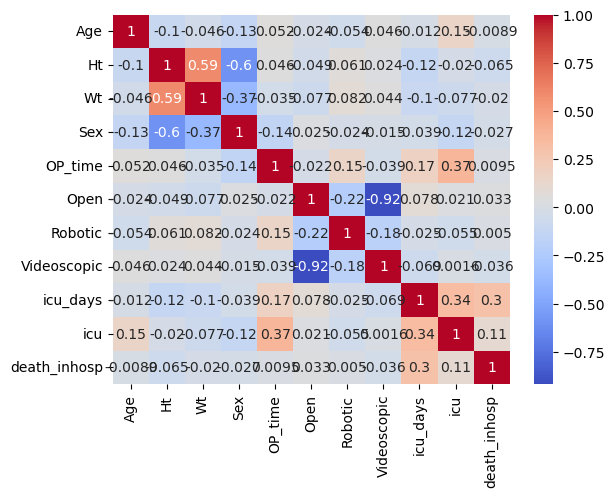

In [9]:
cor_mat = info_new[['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

<Axes: >

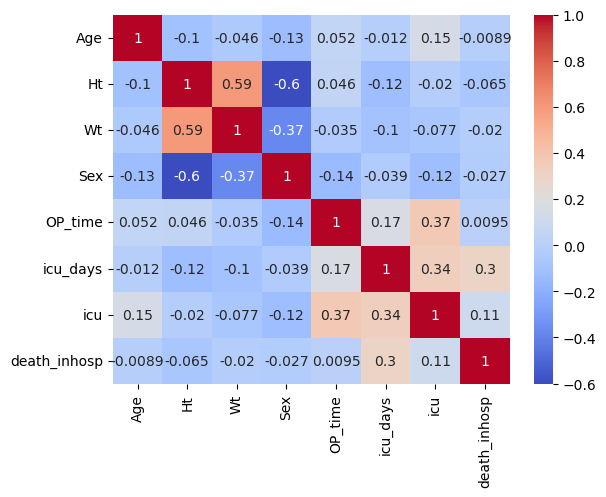

In [10]:
# Remove variables with low correlations

cor_mat = info_new[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat,cmap='coolwarm',annot=True)

# Outlier Detection

### Mahalanobis (we assume our data to be unimodal because all of our individual distributions were unimodal)

In [11]:
num_data = info_new[['Age','Ht','Wt','Sex','OP_time']]
mu = list(np.mean(num_data))
iv = np.linalg.inv(num_data.cov())

/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [12]:
info_new['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)

In [13]:
info_new.head()

,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,icu,death_inhosp,Mahalanobis
0,5955,77.0,160.2,67.5,0,145.0,1,0,0,0,0,0,1.867660
1,2487,54.0,167.3,54.8,0,215.0,1,0,0,0,0,0,1.623615
2,2861,62.0,169.1,69.7,0,32.0,0,0,1,0,0,0,1.575830
3,1903,74.0,160.6,53.0,0,255.0,0,0,1,1,1,0,2.000307
4,4416,66.0,171.0,59.7,0,295.0,1,0,0,13,1,0,2.022579


In [14]:
# Remove data points with top 5% mahalanobis distance
thresh = np.quantile(list(info_new['Mahalanobis']),0.95)
data = info_new[info_new['Mahalanobis'] < thresh]
print(f'We removed {len(info_new[info_new["Mahalanobis"] >= thresh])} outliers, leaving {len(data)} points remaining')

We removed 320 outliers, leaving 6068 points remaining


<Axes: >

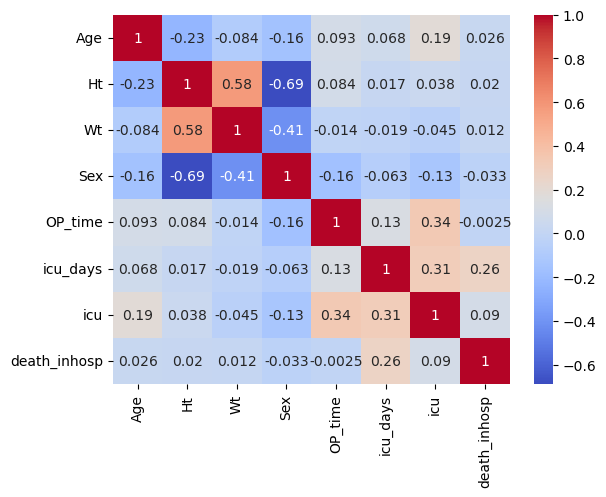

In [15]:
# evaluate change in correlation between height and age
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',annot=True)

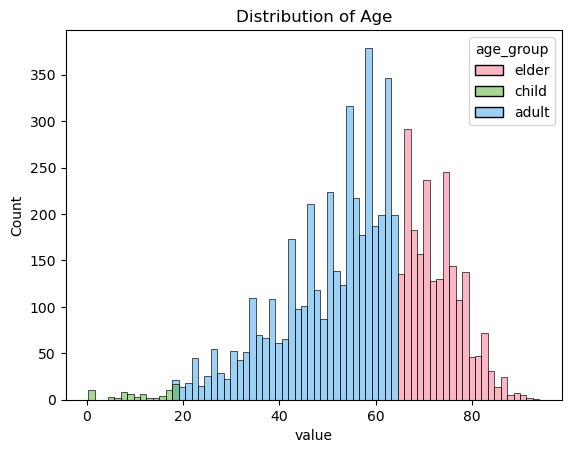

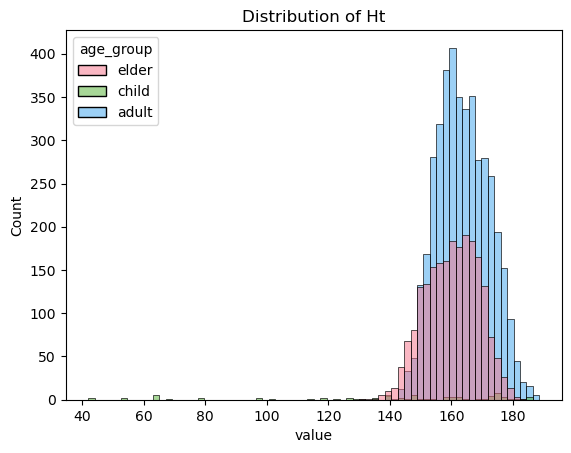

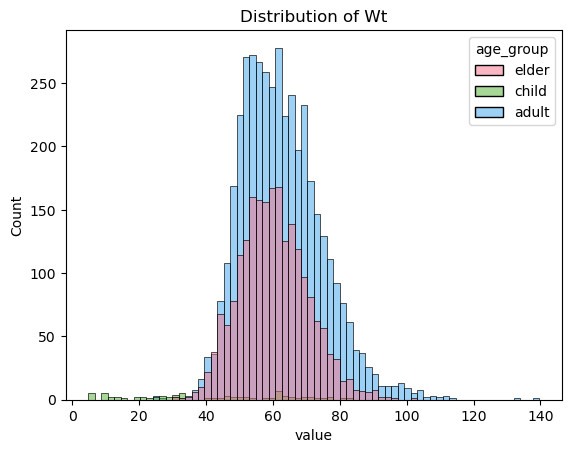

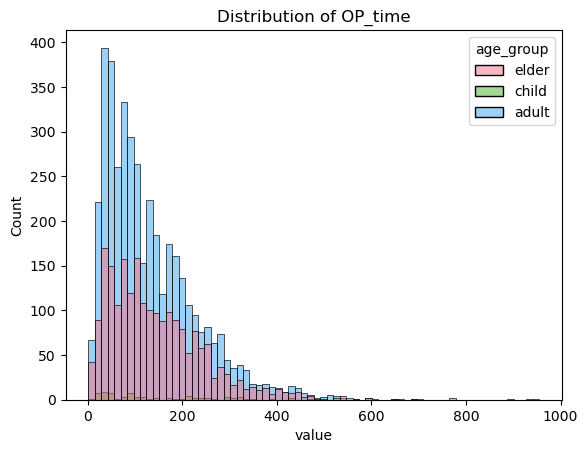

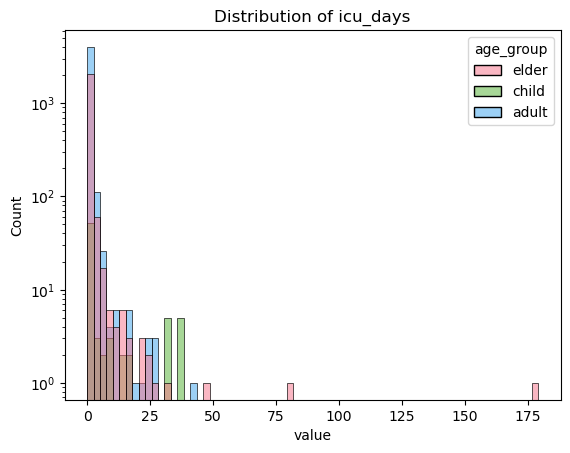

In [16]:
# Stratifying by age

info_new['age_group'] = info_new['Age'].apply(lambda x: 'child' if x < 19 else ('elder' if x > 64 else 'adult'))

for var in ['Age','Ht','Wt','OP_time', 'icu_days']:
    to_plot = info_new.melt(id_vars='age_group', value_vars=var, var_name='variable', value_name='value')
    to_plot['age_group'] = pd.Categorical(to_plot['age_group'], categories=reversed(sorted(to_plot['age_group'].unique())), ordered=True)
    palette = sns.color_palette("husl", n_colors=len(to_plot['age_group'].unique()))

    plt.figure()
    sns.histplot(data=to_plot, x='value', hue='age_group', multiple='layer', bins=70, alpha=0.5, palette=palette)
    plt.title(f'Distribution of {var}')
    if var == 'icu_days':
        plt.yscale('log')
    plt.show()

In [17]:
for var in ['Age','Ht','Wt','Sex','OP_time', 'Open', 'Robotic', 'Videoscopic', 'icu_days', 'icu', 'death_inhosp']:
    print(f'\nFor variable {var}:')
    for g in ['child','adult','elder']:
        print(f'In class {g},')
        if var in ['Sex', 'Open', 'Robotic', 'Videoscopic', 'icu', 'death_inhosp']:
            print(f'mode={stats.mode(info_new[info_new["age_group"]==g][var]).mode[0]}')
            print(f'class balance: {np.sum(info_new[info_new["age_group"]==g][var])} to {len(info_new[info_new["age_group"]==g])-np.sum(info_new[info_new["age_group"]==g][var])}\n')
        else:
            print(f'mean={np.mean(info_new[info_new["age_group"]==g][var])}')
            print(f'standard deviation={np.std(info_new[info_new["age_group"]==g][var])}\n')


For variable Age:
In class child,
mean=11.675675675675675
standard deviation=6.024809312016862

In class adult,
mean=50.184153661464585
standard deviation=10.888893800440727

In class elder,
mean=72.6519311307585
standard deviation=5.484172602364945


For variable Ht:
In class child,
mean=138.98918918918918
standard deviation=40.214057537966866

In class adult,
mean=163.63847779111646
standard deviation=8.383937382770846

In class elder,
mean=160.17812936249422
standard deviation=8.546384868097832


For variable Wt:
In class child,
mean=40.935810810810814
standard deviation=23.001716328837627

In class adult,
mean=62.55960864345739
standard deviation=12.106093865585798

In class elder,
mean=60.10966030711959
standard deviation=10.155852027793363


For variable Sex:
In class child,
mode=0
class balance: 36 to 38

In class adult,
mode=1
class balance: 2241 to 1924

In class elder,
mode=0
class balance: 868 to 1281


For variable OP_time:
In class child,
mean=161.4536036036036
standard d

/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_83148/2856222120.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'mode={stats.mode(info_new[info_new["age_group"]==g][var]).mode[0]}')


In [18]:
data = pd.DataFrame()

for c in ['child','adult','elder']:
    small_data = info_new[info_new['age_group']==c].copy()
    num_data = small_data[['Age','Ht','Wt','Sex','OP_time']]
    mu = list(np.mean(num_data))
    iv = np.linalg.inv(num_data.cov())
    small_data['Mahalanobis'] = num_data.apply(lambda x: distance.mahalanobis(x,mu,iv),axis=1)
    thresh = np.quantile(list(small_data['Mahalanobis']),0.95)
    print(f'removing {len(small_data[small_data["Mahalanobis"] >= thresh])} outliers from {c} class')
    data = pd.concat([data, small_data[small_data['Mahalanobis'] < thresh]], ignore_index=True)

removing 4 outliers from child class
removing 209 outliers from adult class
removing 108 outliers from elder class


/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **

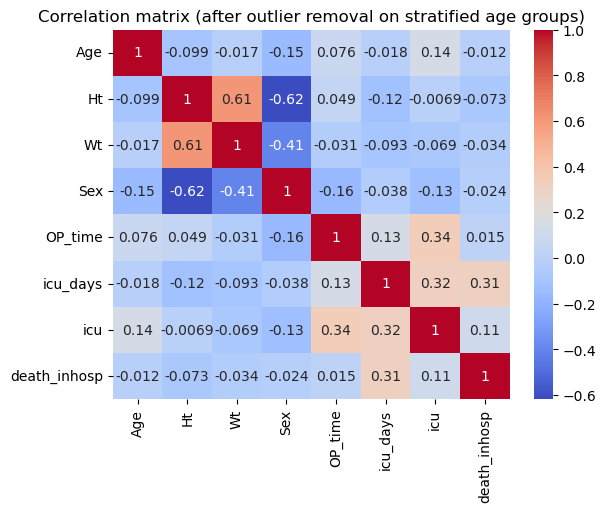

In [19]:
cor_mat_new = data[['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
sns.heatmap(cor_mat_new,cmap='coolwarm',annot=True)
plt.title('Correlation matrix (after outlier removal on stratified age groups)')
plt.show()

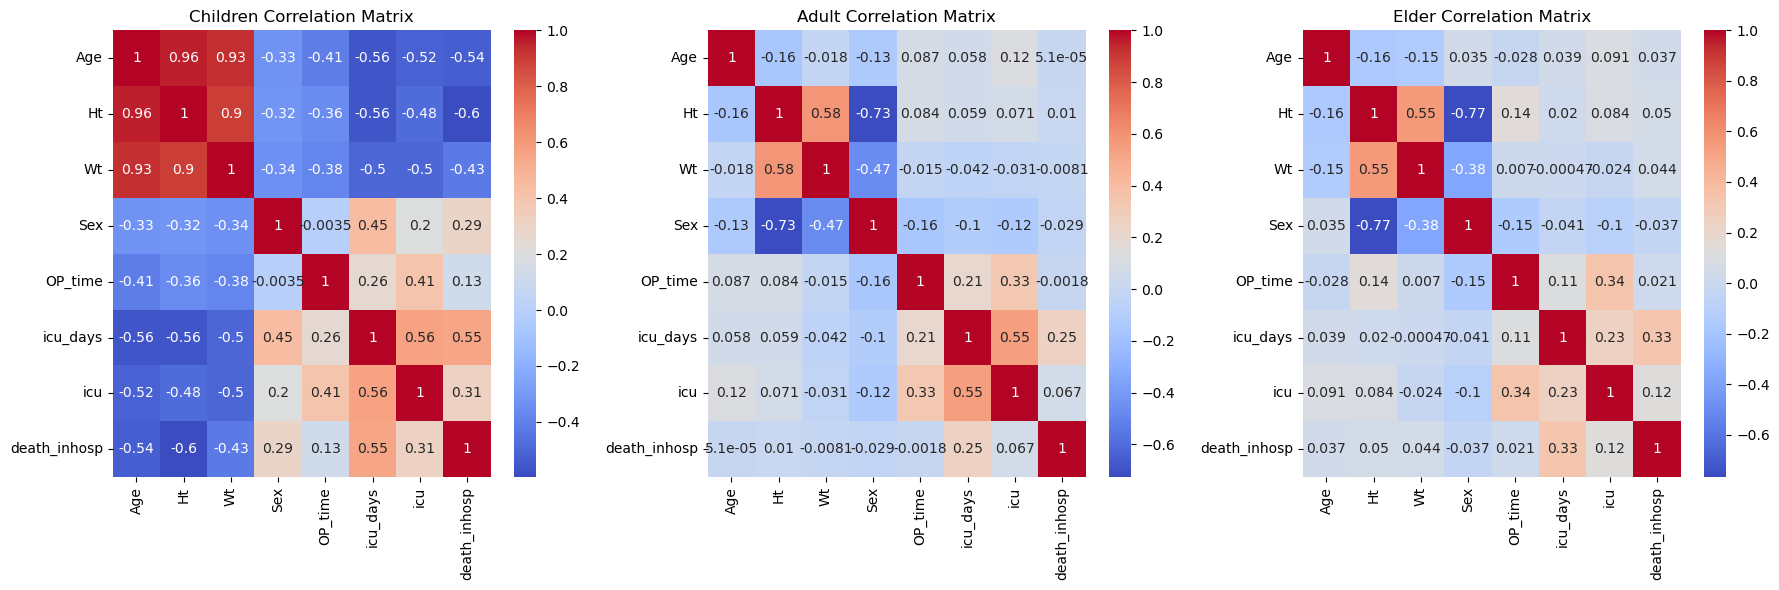

In [20]:
# Correlation matrix by Age class

cor_mat_children = data[data['age_group'] == 'child'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
cor_mat_adults = data[data['age_group'] == 'adult'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()
cor_mat_elders = data[data['age_group'] == 'elder'][['Age','Ht','Wt','Sex','OP_time', 'icu_days', 'icu', 'death_inhosp']].corr()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot heatmaps for each correlation matrix
sns.heatmap(cor_mat_children, ax=axs[0], cmap='coolwarm', annot=True)
sns.heatmap(cor_mat_adults, ax=axs[1], cmap='coolwarm', annot=True)
sns.heatmap(cor_mat_elders, ax=axs[2], cmap='coolwarm', annot=True)

# Set titles for each subplot
axs[0].set_title('Children Correlation Matrix')
axs[1].set_title('Adult Correlation Matrix')
axs[2].set_title('Elder Correlation Matrix')

# Display the plots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Time Series Outlier Detection (SNUADC ECG)

In [21]:
# options for ECG waveforms
ecg_info = df_ids[df_ids['tname'] == 'SNUADC/ECG_II']
ecg_info

,caseid,tname,tid
41,1,SNUADC/ECG_II,8c9161aaae8cb578e2aa7b60f44234d98d2b3344
122,2,SNUADC/ECG_II,62204d727b2e31e42f9602c054c7d9e598b2db05
198,3,SNUADC/ECG_II,2012a9532285255e1051e9be389d69e2778373ba
279,4,SNUADC/ECG_II,be29325ee538657798f5c804bf72596fb3fd47ea
366,5,SNUADC/ECG_II,3431cd35ca4bc15b6de13e4c49b2db56e6bc5a37
...,...,...,...
486118,6384,SNUADC/ECG_II,38fda47c2e06534015012c131657edd66e36f4d2
486191,6385,SNUADC/ECG_II,0e030d618ae6101448128542f7b2964e66ad6272
486266,6386,SNUADC/ECG_II,7f4f673135fff8b4474dcbd852c774aad89e3c0d
486342,6387,SNUADC/ECG_II,66401ffc5c1ef2d8904e021f55c2d745e2bd5936


In [22]:
ecg_time, ecg_data = get_data_for("0e030d618ae6101448128542f7b2964e66ad6272")
valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]

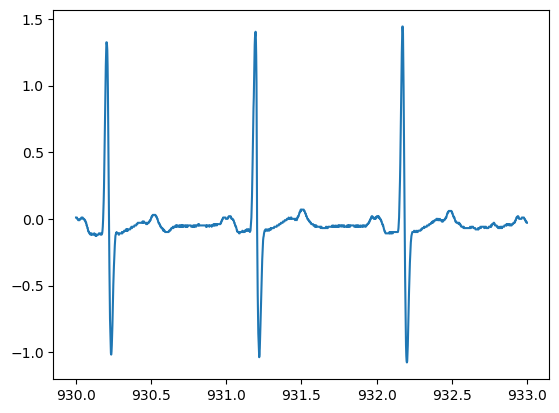

In [27]:
plt.plot(valid_time[15000:16500], valid_data[15000:16500])

In [35]:
periodicity = int(np.round(1 / (valid_time[1] - valid_time[0])))
stl = STL(valid_data, period = periodicity)

In [36]:
ts_decomposed = stl.fit()

NameError: name 'figsize' is not defined

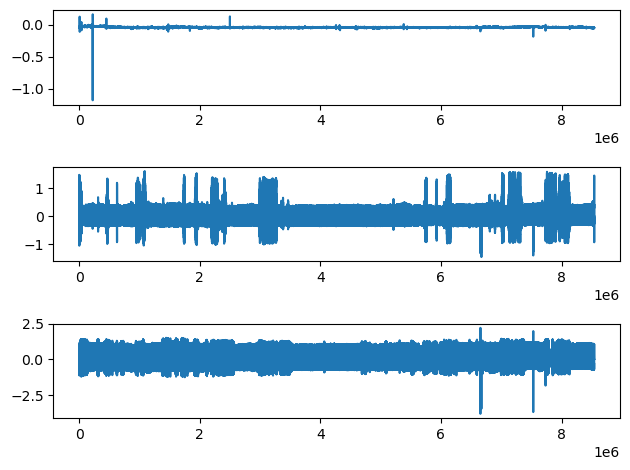

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(ts_decomposed.trend)
ax2.plot(ts_decomposed.seasonal)
ax3.plot(ts_decomposed.resid)
plt.tight_layout()
plt.show()